## Fast Image resizing
**Given a directory of images @path, running this notebook produces the following:**
- path/res_xx/train/   => training images
- path/res_xx/val/     => validation set

** Same as above but at different resolution **

- path/res_yy/train/
- path/res_yy/val/

** Small sample versions of all the above **
- path/res_xx/sample/train/
- path/res_xx/sample/val/
- path/res_yy/sample/train/
- path/res_yy/sample/val/

Notes:
Randomizes the input file order before any processing. Resizes using threaded execution. On MSCOCO dataset, this finishes in 2 minutes. See inputs cell for available controls

### Inputs

In [153]:
# Use this cell to resize large datasets
# # Inputs
# path='/home/rkoppula/Downloads/datasets/mscoco/train2014/'

# # Low and high resolutions. Only square aspect ratio. 
# res = [72, 288] #72x72 and 288x288
# val_perc = 0.2
# set_names = ['train', 'val']
# sample_tr_val_szs = [1000, 200] # Will grab the first 1000 of train and first 200 of val files and copies them to sample folder

In [154]:
# Use this cell to resize random small test datasets. We don't need val set for these, but just use a small percent so we can reuse this code. 
# Inputs
path='/home/rkoppula/Downloads/datasets/rand_test/personal/'

# Low and high resolutions. Only square aspect ratio. 
res = [72, 288] #72x72 and 288x288
val_perc = 0
set_names = ['train', 'val']
sample_tr_val_szs = [1, 1] # Will grab the first 1000 of train and first 200 of val files and copies them to sample folder

In [155]:
%matplotlib inline
import os
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

In [156]:
bc_names = ['res_'+str(x)+'/' for x in res]
bc_paths = [f'{path}{x}' for x in bc_names]
bc_paths_sample = [bc_path+'sample/' for bc_path in bc_paths]

for bc_path, bc_path_sample in zip(bc_paths, bc_paths_sample):
    # Create folders if doesn't exist
    # training
    if not os.path.exists(bc_path):
        os.makedirs(bc_path)
    # small sample
    if not os.path.exists(bc_path_sample):
        os.makedirs(bc_path_sample)

In [157]:
fnames = list(glob.iglob(path+'*.jpg'))
pickle.dump(fnames, open(path+'fnames.pkl', 'wb'))
fnames = pickle.load(open(path+'fnames.pkl', 'rb'))
fnames = np.random.permutation(fnames)
pickle.dump(fnames, open(path+'fnames_r.pkl', 'wb'))
fnames = pickle.load(open(path+'fnames_r.pkl', 'rb'))
n = len(fnames); n

2

In [158]:
# validation split
val_start_idx = np.floor(n*(1-val_perc)).astype('int') #20% val set
fnames_list = [fnames[0:val_start_idx], fnames[val_start_idx:]]

In [159]:
def _resize(img):
    shortest = min(img.width,img.height)
    resized = np.round(np.multiply(new_s/shortest, img.size)).astype(int)
    return img.resize(resized, Image.BILINEAR)

In [160]:
def resize_img(i):
    # USES GLOBAL NAME fnames
    img = Image.open(fnames_to_resize[i])
    s = np.array(img).shape
    if len(s)!=3 or s[2]!=3: return
    return _resize(img)

In [161]:
def get_slice(p, n): return slice((p-n+1)//2, p-(p-n)//2)

def app_img(r):
    tl.place[:] = (np.array(r)[get_slice(r.size[1],new_s), get_slice(r.size[0],new_s)] 
        if r else 0.)
    arr.append(tl.place)

In [162]:
# Serial version
def serial_resize():
    for i in range(n): app_img(resize_img(i))
    arr.flush()

#%time serial_resize()

In [163]:
def parallel_resize(n):
    step=6400
    for i in range(0, n, step):
        with ThreadPoolExecutor(max_workers=16) as execr:
            res = execr.map(resize_img, range(i, min(i+step, n)))
            for r in res: app_img(r)
        arr.flush()


In [164]:
#For each resolution, generate training and val sets
for resolution, bc_path in zip(res,bc_paths):
    new_s = resolution
    #thread local mem
    tl = threading.local()
    tl.place = np.zeros((new_s,new_s,3), 'uint8')
    for i in range(2):    
        fnames_to_resize=fnames_list[i]
        set_name = set_names[i]
        # Init bcolz dest array
        arr = bcolz.carray(np.empty((0, new_s, new_s, 3), 'float32'), 
                       chunklen=32, mode='w', rootdir=bc_path+set_name)
        parallel_resize(len(fnames_to_resize))


### Read back and sanity check

In [165]:
res_72_train = bcolz.open(path+'/res_72/train')
res_72_val = bcolz.open(path+'/res_72/val')

In [166]:
res_288_train = bcolz.open(path+'/res_288/train')
res_288_val = bcolz.open(path+'/res_288/val')

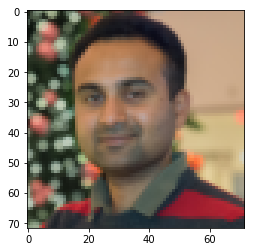

In [167]:
plt.imshow(res_72_train[0].astype('uint8'))

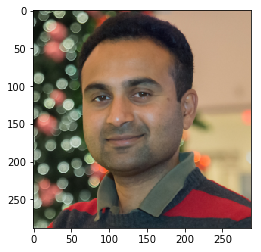

In [168]:
plt.imshow(res_288_train[0].astype('uint8'))

### Generate small sample files

In [169]:
#For each resolution, generate training and val sets
for res_idx, (resolution, bc_path) in enumerate(zip(res,bc_paths)):
    new_s = resolution
    bc_path_sample = bc_paths_sample[res_idx]
    for i in range(2):
        size=sample_tr_val_szs[i]
        set_name = set_names[i]
        arr = bcolz.open(bc_path+set_name)
        
        # Init bcolz dest array
        sample_arr = bcolz.carray(np.empty((0, new_s, new_s, 3), 'float32'), 
                       chunklen=32, mode='w', rootdir=bc_path_sample+set_name)
        sample_arr.append(arr[:size])
        sample_arr.flush()


In [170]:
st72 = bcolz.open(path+'/res_72/sample/train')
sv72 = bcolz.open(path+'/res_72/sample/val')

st288 = bcolz.open(path+'/res_288/sample/train')
sv288 = bcolz.open(path+'/res_288/sample/val')

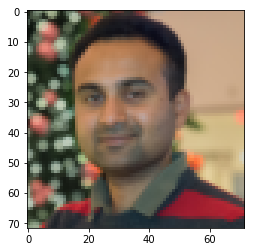

In [171]:
plt.imshow(st72[0].astype('uint8'))

In [172]:
plt.imshow(sv72[0].astype('uint8'))

IndexError: index out of range

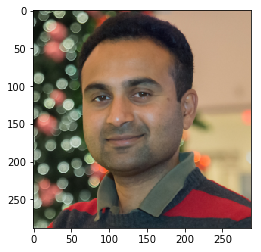

In [173]:
plt.imshow(st288[0].astype('uint8'))

In [ ]:
plt.imshow(sv288[0].astype('uint8'))